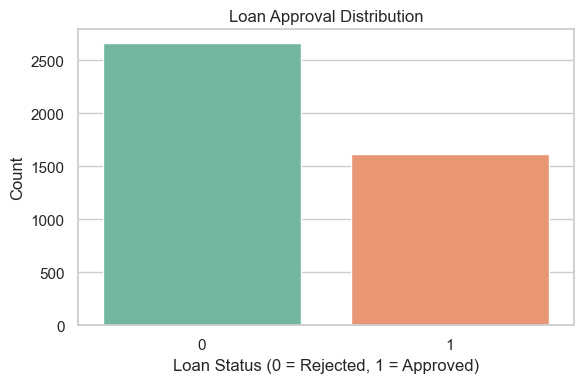

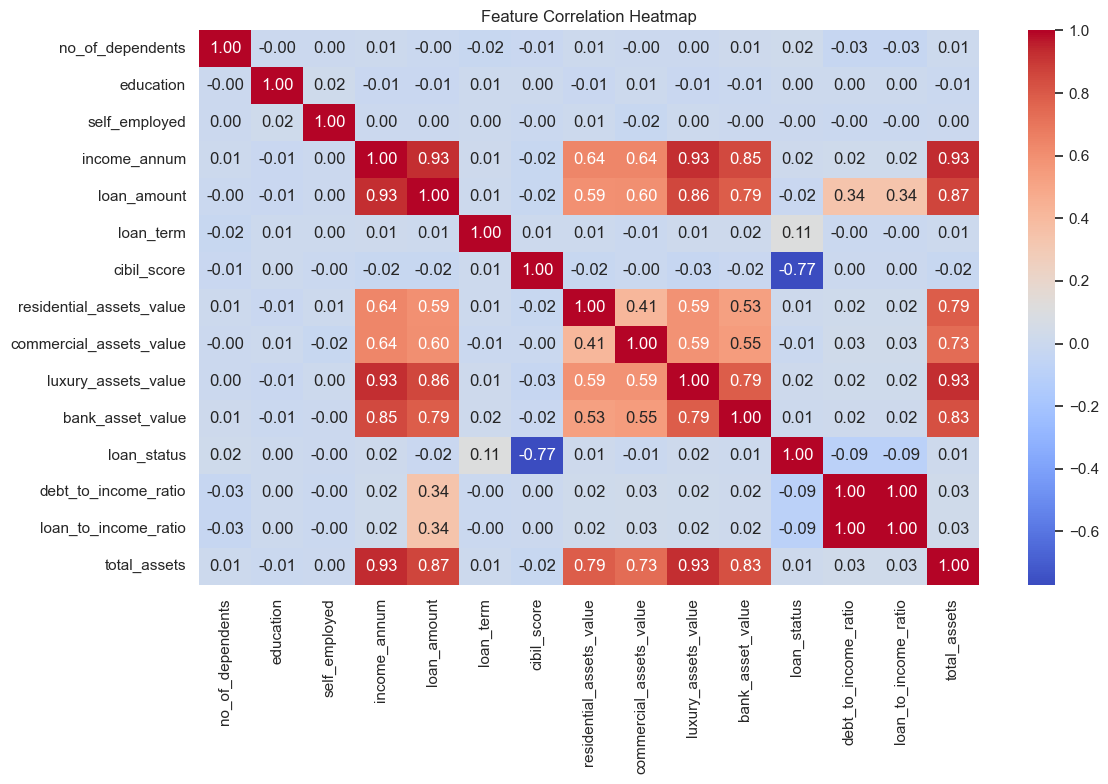

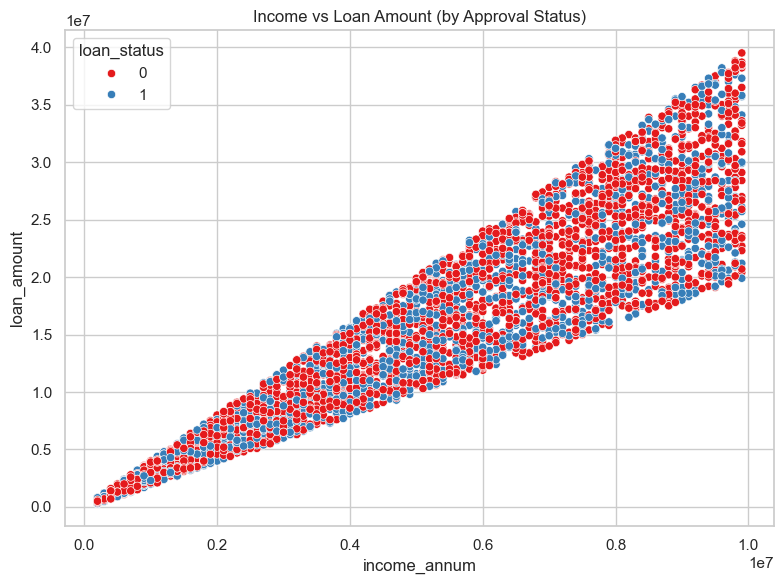

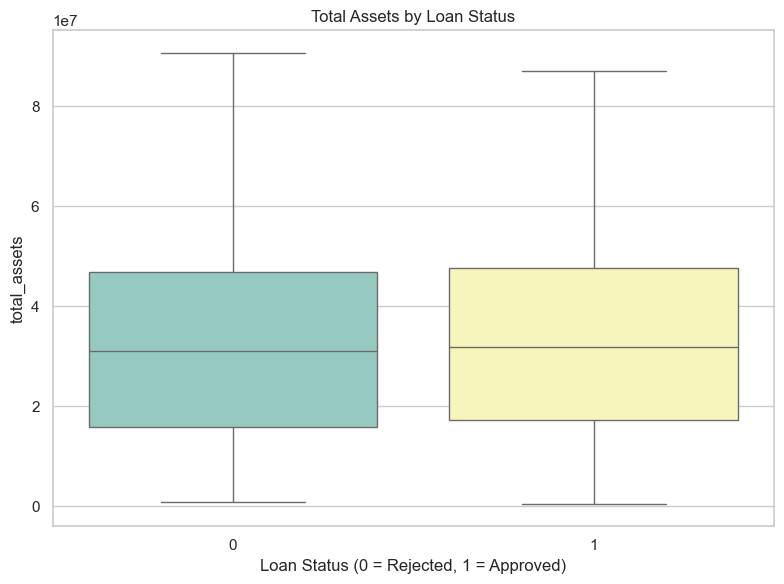


--- Model Evaluation ---
Accuracy       : 0.9953
Precision      : 1.0000
Recall         : 0.9906
F1-Score       : 0.9953
ROC-AUC Score  : 0.9953
Cross-Validation F1: 0.9953 (+/- 0.0043)


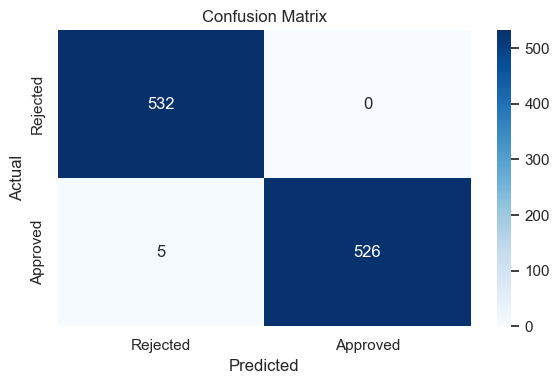

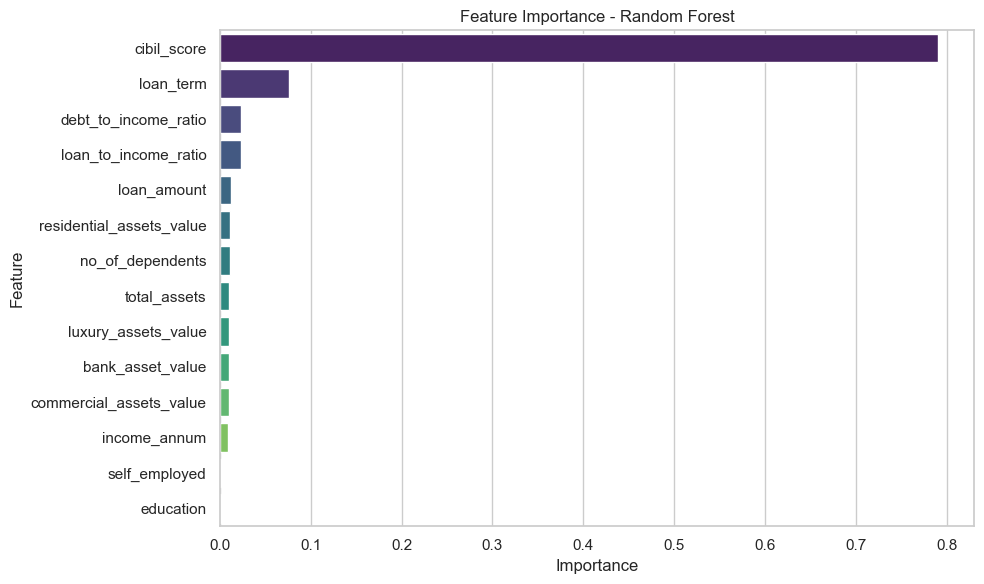

<Figure size 1000x600 with 0 Axes>

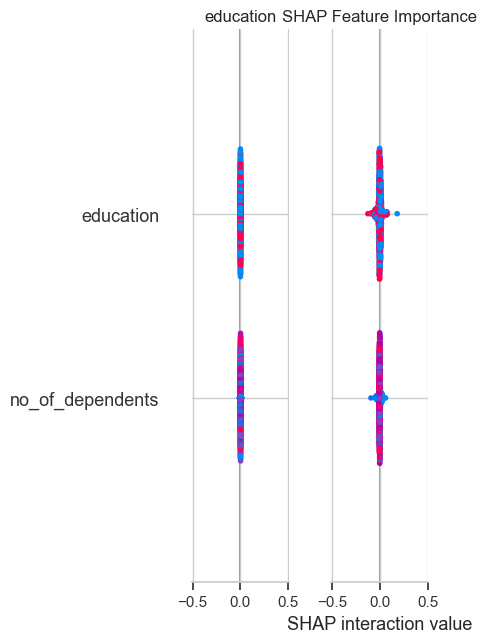


✅ Model saved as 'loan_approval_model.pkl'


In [1]:
# ----------------------------------------
# Enhanced Loan Approval Prediction with Visualizations
# ----------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='Set2')

# -------------------------
# 1. Load Dataset
# -------------------------
data = pd.read_csv('D:/WS CubeTech-classic_models_dataset/ML Module/ML Milestone Project/Dataset/loan_approval_dataset.csv')
data.columns = data.columns.str.strip()
data.drop_duplicates(inplace=True)

# -------------------------
# 2. Encode & Clean
# -------------------------
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'].astype(str).str.strip())
data['self_employed'] = label_encoder.fit_transform(data['self_employed'].astype(str).str.strip())
data['loan_status'] = label_encoder.fit_transform(data['loan_status'].astype(str).str.strip())

asset_columns = [
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value'
]
for col in asset_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').clip(lower=0)

data['loan_amount'] = pd.to_numeric(data['loan_amount'], errors='coerce')
data['income_annum'] = pd.to_numeric(data['income_annum'], errors='coerce')

# -------------------------
# 3. Feature Engineering
# -------------------------
data['debt_to_income_ratio'] = (data['loan_amount'] / data['income_annum']).replace([np.inf, -np.inf], 0)
data['loan_to_income_ratio'] = (data['loan_amount'] / data['income_annum']).replace([np.inf, -np.inf], 0)
data['total_assets'] = data[asset_columns].sum(axis=1)

# -------------------------
# 4. EDA Visualizations
# -------------------------

# 4.1 Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=data, palette='Set2')
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Status (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()

# 4.2 Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data.drop(['loan_id'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# 4.3 Income vs Loan Amount scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='income_annum', y='loan_amount', hue='loan_status', data=data, palette='Set1')
plt.title("Income vs Loan Amount (by Approval Status)")
plt.tight_layout()
plt.savefig("income_vs_loan.png")
plt.show()

# 4.4 Total assets boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_status', y='total_assets', data=data, palette='Set3')
plt.title("Total Assets by Loan Status")
plt.xlabel("Loan Status (0 = Rejected, 1 = Approved)")
plt.tight_layout()
plt.savefig("assets_by_status.png")
plt.show()

# -------------------------
# 5. Prepare Features
# -------------------------
X = data.drop(['loan_id', 'loan_status'], axis=1)
y = data['loan_status']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# -------------------------
# 6. Train Model
# -------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# -------------------------
# 7. Evaluate Model
# -------------------------
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5, scoring='f1')

print("\n--- Model Evaluation ---")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-Score       : {f1:.4f}")
print(f"ROC-AUC Score  : {roc_auc:.4f}")
print(f"Cross-Validation F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# -------------------------
# 8. Confusion Matrix
# -------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# -------------------------
# 9. Feature Importance
# -------------------------
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('feature_importance_seaborn.png')
plt.show()

# -------------------------
# 10. SHAP Explainability
# -------------------------
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_plot, X_test, feature_names=X.columns, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.show()
except Exception as e:
    print(f"\nSHAP error: {e}")

# -------------------------
# 11. Save Model
# -------------------------
joblib.dump(model, 'loan_approval_model.pkl')
print("\n✅ Model saved as 'loan_approval_model.pkl'")


In [ ]:
pip